In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/segmentation/Segmented Data/Val/Tomato___Late_blight/532b2c20-d17b-4b3e-a69e-54a6e5343014___GHLB2 Leaf 9004_final_masked.jpg
/kaggle/input/segmentation/Segmented Data/Val/Tomato___Late_blight/5c0dc87a-f671-4085-93c5-1454ee859caf___RS_Late.B 6271_final_masked.jpg
/kaggle/input/segmentation/Segmented Data/Val/Tomato___Late_blight/d730c413-51de-4f47-86bd-e0763f5a5298___GHLB2 Leaf 8894_final_masked.jpg
/kaggle/input/segmentation/Segmented Data/Val/Tomato___Late_blight/5688ea99-c949-41d0-bbab-9cbf0ffb8bcd___GHLB2 Leaf 8677_final_masked.jpg
/kaggle/input/segmentation/Segmented Data/Val/Tomato___Late_blight/57c53f65-3137-41d3-9bf7-7ac867f3efe8___RS_Late.B 6255_final_masked.jpg
/kaggle/input/segmentation/Segmented Data/Val/Tomato___Late_blight/f14bdea6-8f1d-47c4-ab6f-dbf05c994901___GHLB2 Leaf 9046_final_masked.jpg
/kaggle/input/segmentation/Segmented Data/Val/Tomato___Late_blight/998dafd6-dac5-41f7-84d9-f96c9593dda3___RS_Late.B 7075_final_masked.jpg
/kaggle/input/segmentation/Seg

In [2]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [3]:
# Set image dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [4]:
# Define directories
image_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images'
mask_dir = '/kaggle/input/segmentation/Segmented Data/Train'

In [5]:
# Function to load images and masks, resizing them to the target dimensions
def load_images_from_dir(image_dir, mask_dir):
    images = []
    masks = []
    
    image_subfolders = os.listdir(image_dir)
    
    for subfolder in image_subfolders:
        subfolder_image_path = os.path.join(image_dir, subfolder)
        subfolder_mask_path = os.path.join(mask_dir, subfolder)

        if os.path.isdir(subfolder_image_path):
            image_files = os.listdir(subfolder_image_path)

            for image_file in image_files:
                image_path = os.path.join(subfolder_image_path, image_file)
                mask_file = find_mask_for_image(image_file, subfolder_mask_path)
                
                if mask_file:
                    mask_path = os.path.join(subfolder_mask_path, mask_file)
                    
                    try:
                        # Load and resize images and masks
                        image = Image.open(image_path).resize((IMG_WIDTH, IMG_HEIGHT))
                        mask = Image.open(mask_path).resize((IMG_WIDTH, IMG_HEIGHT))
                        
                        # Convert to numpy arrays
                        image = np.array(image)
                        mask = np.array(mask)
                        
                        # Append to lists
                        images.append(image)
                        masks.append(mask)
                    except Exception as e:
                        print(f"Error loading image or mask {image_file}: {e}")
                else:
                    print(f"No matching mask found for image {image_file}. Skipping.")
    
    return np.array(images), np.array(masks)


In [6]:
# Function to find corresponding masks
# Loop through the mask files to find a match for the image name
def find_mask_for_image(image_file, mask_dir):
    image_name_without_extension = os.path.splitext(image_file)[0]
    mask_files = os.listdir(mask_dir)
    for mask_file in mask_files:
        if image_name_without_extension in mask_file:
            return mask_file
    return None


In [7]:
# Load the images and masks from the directories

images, masks = load_images_from_dir(image_dir, mask_dir)

In [8]:
print(f'Loaded {len(images)} images and {len(masks)} masks.')

Loaded 1320 images and 1320 masks.


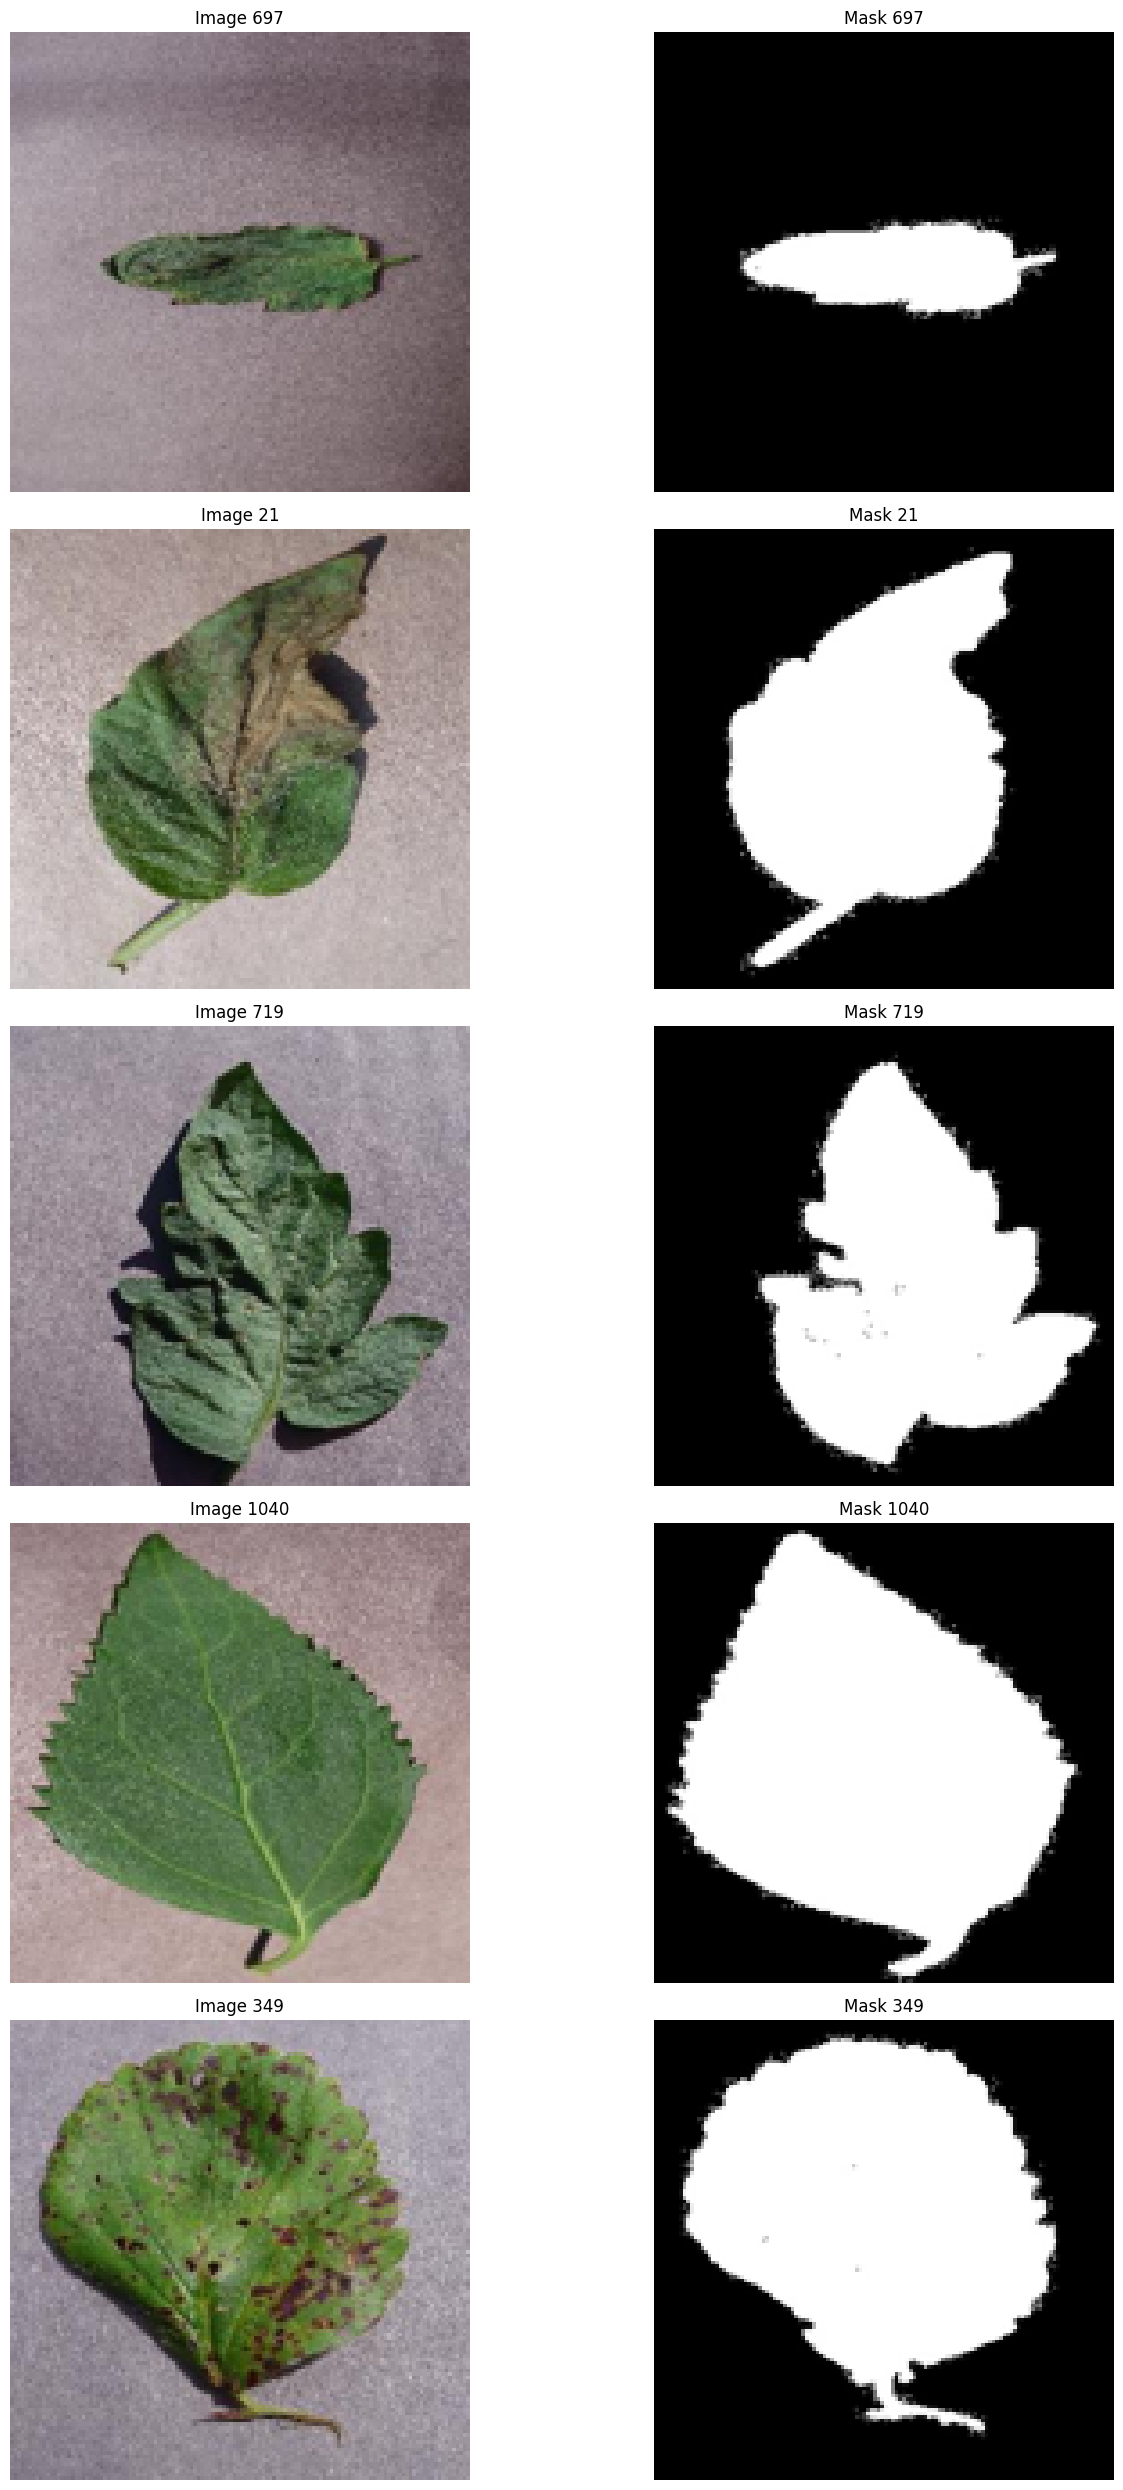

In [9]:
# Visualizations
def visualize_samples(images, masks, num_samples=5):
    # Select a few random indices to display
    num_samples = min(num_samples, len(images))
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    plt.figure(figsize=(15, num_samples * 5))
    
    for i, idx in enumerate(indices):
        # Display the image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(images[idx])
        plt.title(f"Image {idx}")
        plt.axis("off")
        
        # Display the mask
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(masks[idx], cmap='gray')
        plt.title(f"Mask {idx}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize a few samples
visualize_samples(images, masks, num_samples=5)

In [10]:
# Normalize the images (scaling pixel values to range [0, 1])
images = images / 255.0
# Convert masks to binary values (0 or 1)
masks = (masks > 0).astype(np.float32)

In [11]:
# Split the dataset into training and validation sets (80% training, 20% validation)

X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


# **Build the U-Net model** 

In [12]:
# Define U-Net blocks
# Define U-Net convolutional block (used in both contracting and expanding paths)

def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", 
                               kernel_initializer="he_normal", padding="same")(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", 
                               kernel_initializer="he_normal", padding="same")(x)
    return x

In [13]:
# Define U-Net upsampling block (used to combine previous and current features during expansion)

def upsample_block(inputs, conv_prev, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    concat = tf.keras.layers.concatenate([up, conv_prev])
    conv = conv_block(concat, num_filters)
    return conv

In [14]:
# Input layer
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255.0)(inputs)


In [15]:
# Contracting path
c1 = conv_block(s, 16)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)

In [16]:
# Expanding path
# upsample and concatenate with c4
# upsample and concatenate with c3
# upsample and concatenate with c2
# upsample and concatenate with c1
c6 = upsample_block(c5, c4, 128)
c7 = upsample_block(c6, c3, 64)
c8 = upsample_block(c7, c2, 32)
c9 = upsample_block(c8, c1, 16)


In [17]:
# Output layer (single channel for binary segmentation, sigmoid activation for probability output)
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [18]:
# Compile the model
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint('model.keras', verbose=1, save_best_only=True)
]

In [21]:
# Train the model
results = model.fit(
    X_train, 
    Y_train, 
    validation_data=(X_val, Y_val), 
    batch_size=16, 
    epochs=25, 
    callbacks=callbacks
)

Epoch 1/25


I0000 00:00:1734214580.581871    2223 service.cc:145] XLA service 0x7bd800002200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734214580.581956    2223 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 6/66 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5083 - loss: 0.6929

I0000 00:00:1734214596.906854    2223 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5554 - loss: 0.6702
Epoch 1: val_loss improved from inf to 0.66551, saving model to model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.5550 - loss: 0.6702 - val_accuracy: 0.4706 - val_loss: 0.6655
Epoch 2/25
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7207 - loss: 0.6520
Epoch 2: val_loss improved from 0.66551 to 0.60828, saving model to model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7223 - loss: 0.6507 - val_accuracy: 0.7798 - val_loss: 0.6083
Epoch 3/25
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7866 - loss: 0.5907
Epoch 3: val_loss improved from 0.60828 to 0.49459, saving model to model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7864 - loss: 0.5899 - val_accuracy: 0.7795 - val_loss: 0.4946
Epoch 4/25
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7889 - loss: 0.4748
Epoch 4: val_loss improved from 0.49459 to 0.46041, saving model to model.keras
66/66 

In [22]:
import os

# Print the current working directory
print("Current Working Directory:", os.getcwd())

# List all files in the directory
print("Files in the directory:", os.listdir(os.getcwd()))


Current Working Directory: /kaggle/working
Files in the directory: ['.virtual_documents', 'model.h5', 'model.keras']


In [23]:
model.save('/kaggle/working/model.h5', save_format='h5')

In [24]:
# Verify the model file is saved
print("Files in /kaggle/working:", os.listdir('/kaggle/working'))

Files in /kaggle/working: ['.virtual_documents', 'model.h5', 'model.keras']


In [25]:
from tensorflow.keras.models import load_model

# Load the model from the working directory
model = load_model('/kaggle/working/model.h5')


In [26]:
# Evaluate on validation data
val_image_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Val/images'
val_mask_dir = '/kaggle/input/segmentation/Segmented Data/Val'

val_images, val_masks = load_images_from_dir(val_image_dir, val_mask_dir)
val_images = val_images / 255.0
val_masks = (val_masks > 0).astype(np.float32)

# Evaluate
loss, accuracy = model.evaluate(val_images, val_masks)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9581 - loss: 0.1228
Validation Loss: 0.12223899364471436
Validation Accuracy: 0.9587949514389038


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


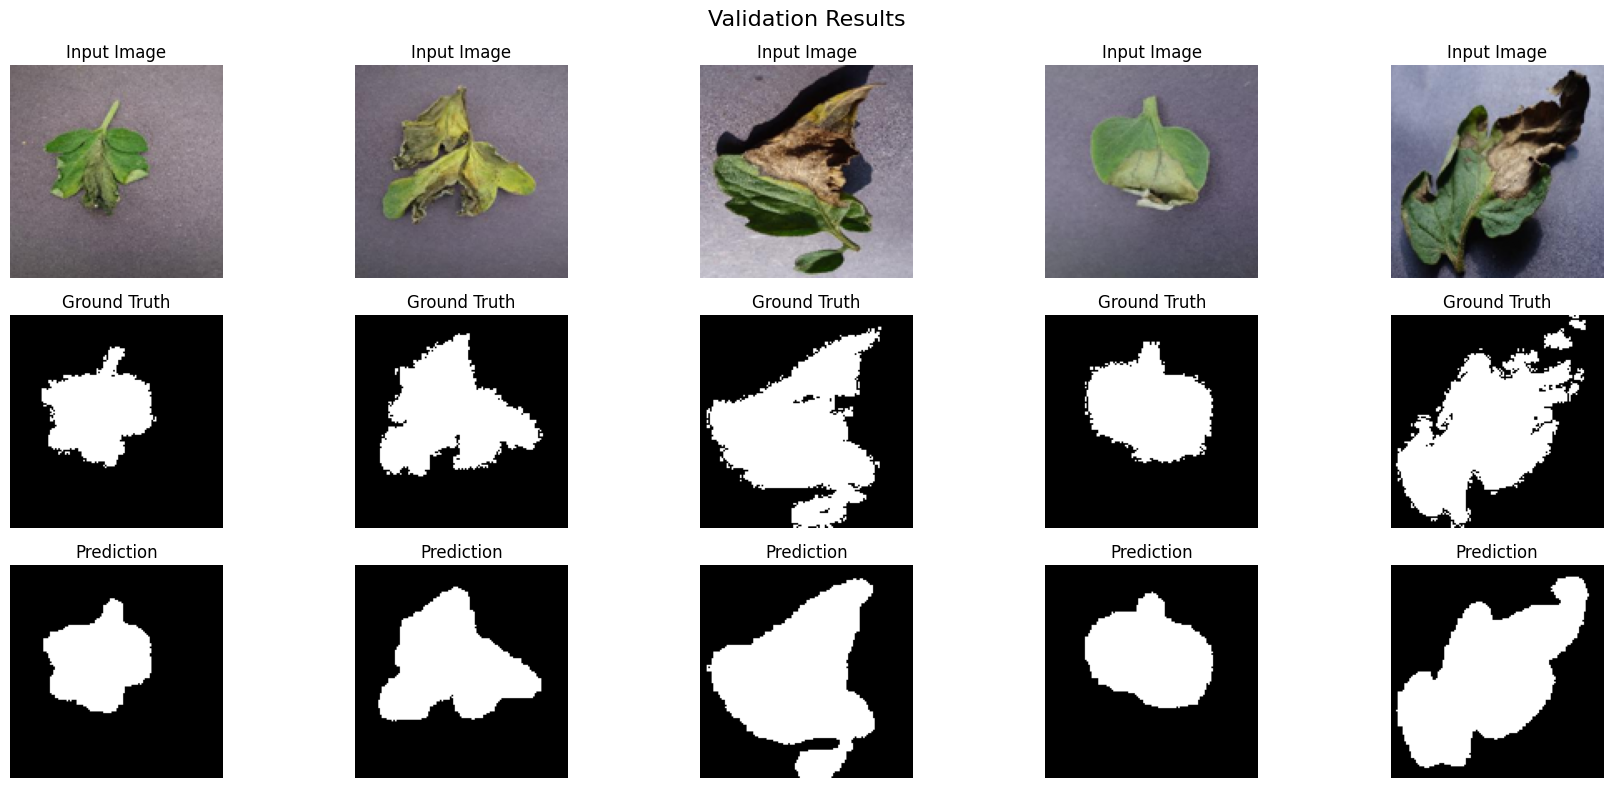

In [35]:
# Generate predictions on validation data
val_predictions = model.predict(val_images)

# Binarize predictions for visualization
val_predictions_binary = (val_predictions > 0.5).astype(np.float32)

# Function to visualize validation data
def plot_validation_results(images, masks, predictions, title="Validation Results"):
    plt.figure(figsize=(18, 8))
    for i in range(5):  # Display 5 samples
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title("Input Image")
        
        plt.subplot(3, 5, i + 6)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Ground Truth")
        
        plt.subplot(3, 5, i + 11)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title("Prediction")
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize validation results
plot_validation_results(val_images, val_masks, val_predictions_binary)


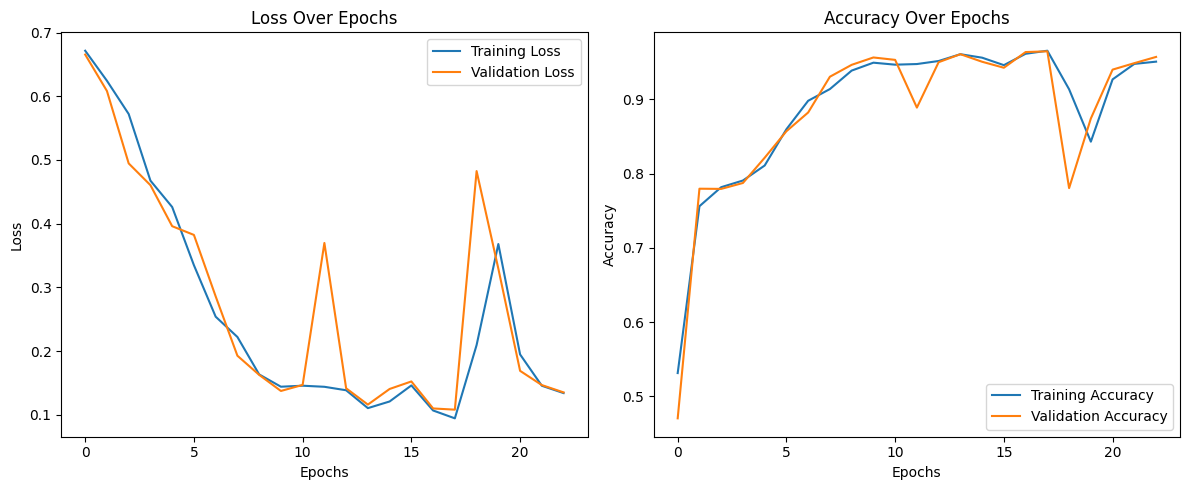

In [36]:
# Visualize predictions
def display_predictions(model, X_val, Y_val, num_samples=5):
    plt.figure(figsize=(15, num_samples * 5))
    
    for i in range(num_samples):
        idx = random.randint(0, len(X_val) - 1)  # Pick a random sample
        
        image = X_val[idx]
        true_mask = Y_val[idx]
        predicted_mask = model.predict(image[np.newaxis, ...])[0]
        
        # Binarize predicted mask for better visualization
        predicted_mask = (predicted_mask > 0.5).astype(np.float32)
        
        # Display the image, true mask, and predicted mask
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis("off")
        
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask, cmap='gray')  # Removed the extra indexing
        plt.title("True Mask")
        plt.axis("off")
        
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predicted_mask, cmap='gray')  # Removed the extra indexing
        plt.title("Predicted Mask")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Call the visualization functions
plot_training_history(results)



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


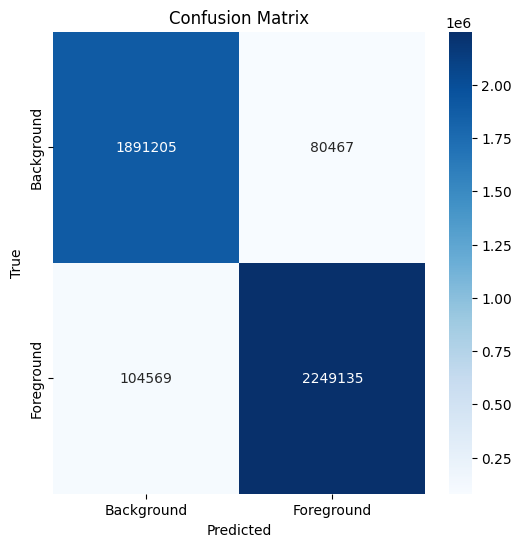

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Function to compute confusion matrix for segmentation
def compute_confusion_matrix(y_true, y_pred):
    # Flatten the arrays to 1D
    y_true_flat = y_true.flatten()
    y_pred_flat = (y_pred > 0.5).flatten()  # Binarize predictions for thresholding
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    return cm

# Function to plot confusion matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Foreground'], 
                yticklabels=['Background', 'Foreground'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Compute confusion matrix for the whole validation set
all_preds = model.predict(X_val)
cm = compute_confusion_matrix(Y_val, all_preds)

# Plot confusion matrix
plot_confusion_matrix(cm)


In [39]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import numpy as np

# Function to compute precision, recall, accuracy, and F1 score
def compute_metrics(y_true, y_pred):
    # Flatten the arrays to 1D
    y_true_flat = y_true.flatten()
    y_pred_flat = (y_pred > 0.5).flatten()  # Binarize predictions for thresholding
    
    # Confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    
    # Compute metrics
    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    f1 = f1_score(y_true_flat, y_pred_flat)
    
    return cm, precision, recall, accuracy, f1

# Function to display the metrics
def display_metrics(cm, precision, recall, accuracy, f1):
    print("Confusion Matrix:")
    print(cm)
    
    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Evaluate on the whole validation set
all_preds = model.predict(X_val)

# Compute metrics
cm, precision, recall, accuracy, f1 = compute_metrics(Y_val, all_preds)

# Display the metrics
display_metrics(cm, precision, recall, accuracy, f1)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:
[[1891205   80467]
 [ 104569 2249135]]

Precision: 0.9655
Recall: 0.9556
Accuracy: 0.9572
F1 Score: 0.9605
